In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['FG_CO2', 'FG_ALT_CO2', 'POC_FLUX_100m']

In [4]:
experiment = 'esm-hist'
ds_expr = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment)
print(ds_expr)
ds_expr_ann = esmlab_wrap.compute_ann_mean(ds_expr)
# print(ds_expr_ann)

<xarray.Dataset>
Dimensions:        (d2: 2, ensemble: 2, region: 7, time: 1980)
Coordinates:
  * region         (region) object 'Global' 'SouOce' ... 'NH_high_lat'
  * time           (time) object 1850-01-16 13:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: d2, ensemble
Data variables:
    time_bound     (time, d2) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    FG_CO2         (time, region, ensemble) float32 0.016169317 ... 0.3644153
    FG_ALT_CO2     (time, region, ensemble) float32 -0.06176695 ... 0.12535314
    POC_FLUX_100m  (time, region, ensemble) float32 7.219508 ... 0.020135418
Attributes:
    title:             b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001
    history:           created by /glade/work/klindsay/analysis/CESM2_coup_ca...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variab

In [5]:
# load Dataset for corresponding experiment_ctrl
experiment_ctrl = data_catalog.find_in_index(experiment=experiment).ctrl_experiment.unique()[0]
print(experiment_ctrl)
ds_ctrl = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment_ctrl)
print(ds_ctrl)
ds_ctrl_ann = esmlab_wrap.compute_ann_mean(ds_ctrl)
# print(ds_ctrl_ann)

esm-piControl
<xarray.Dataset>
Dimensions:        (d2: 2, region: 7, time: 6000)
Coordinates:
  * time           (time) object 0001-01-16 12:59:59 ... 0500-12-16 12:00:00
  * region         (region) object 'Global' 'SouOce' ... 'NH_high_lat'
Dimensions without coordinates: d2
Data variables:
    FG_CO2         (time, region) float32 -0.22678268 0.004187052 ... 0.17730378
    time_bound     (time, d2) object 0001-01-01 01:59:59 ... 0501-01-01 00:00:00
    FG_ALT_CO2     (time, region) float32 -0.23439533 0.04799303 ... 0.15178946
    POC_FLUX_100m  (time, region) float32 7.004047 3.005962 ... 0.02268768
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-esm-piControl.001
    history:           created by /glade/work/klindsay/analysis/CESM2_coup_ca...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
   

In [6]:
# add FG_ANTH_CO2 to datasets
for ds in [ds_expr_ann, ds_ctrl_ann]:
    ds['FG_ANTH_CO2'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
# print(ds_expr_ann)
# print(ds_ctrl_ann)
varnames.append('FG_ANTH_CO2')

In [7]:
# construct year range of experiment_ctrl to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).ctrl_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0001-01-01', '0366-01-01')


In [8]:
# compute experiment_ctrl mean, for detrending
ds_ctrl_ann_slice_mean = ds_ctrl_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_ctrl_ann_slice_mean.FG_CO2)
print(ds_ctrl_ann_slice_mean.FG_ALT_CO2)
print(ds_ctrl_ann_slice_mean.FG_ANTH_CO2)
print(ds_ctrl_ann_slice_mean.POC_FLUX_100m)

<xarray.DataArray 'FG_CO2' (region: 7)>
array([-0.00757916,  0.23777788, -0.17102537,  0.52422527, -0.99484742,
        0.36753792,  0.26653043])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'NH_mid_lat' 'NH_high_lat'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ALT_CO2' (region: 7)>
array([-0.03787079,  0.22682643, -0.17844744,  0.51876194, -1.00300461,
        0.36012544,  0.26469387])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'NH_mid_lat' 'NH_high_lat'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux, Alternative CO2
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ANTH_CO2' (region: 7)>
array([0.03029163, 0.01095145, 0.00742207, 0.00546333, 0.00815719,
       0.00741248, 0.00183656])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'NH_mid_l

In [9]:
ds_expr_ann_detrended = ds_expr_ann - ds_ctrl_ann_slice_mean

In [10]:
# add cummulate flux vars to datasets
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

# print(ds_expr_ann)
# print(ds_expr_ann_detrended)

array([150.61958487, 149.13220116])

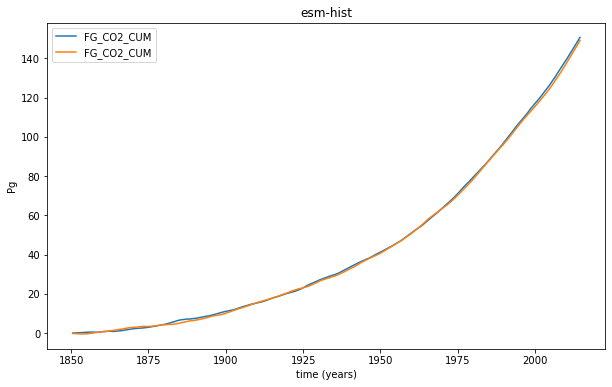

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([152.0766074 , 151.39078622])

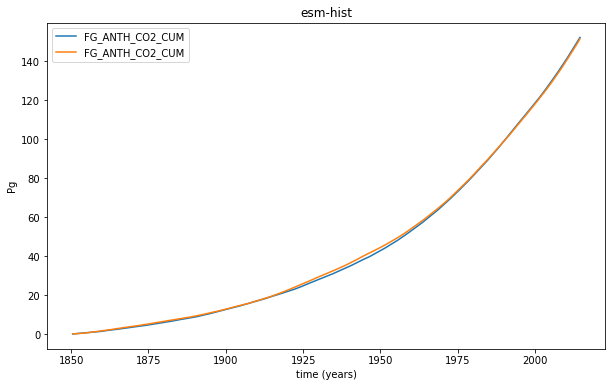

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([151.87014659, 150.38276288])

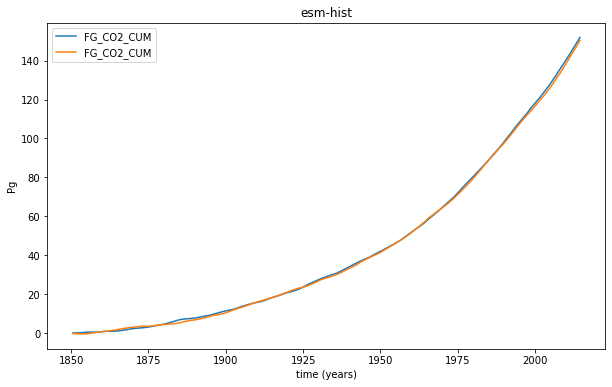

In [13]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([147.07848905, 146.39266786])

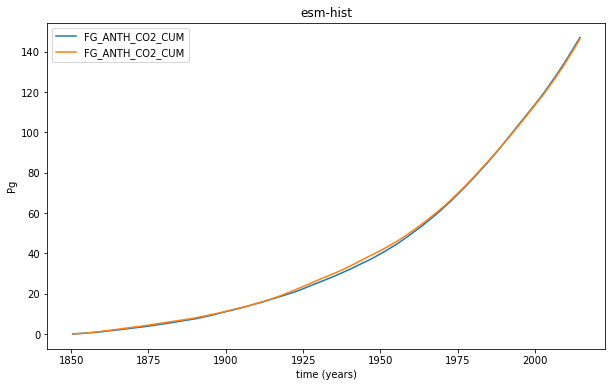

In [14]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([4.79165754, 3.99009502])

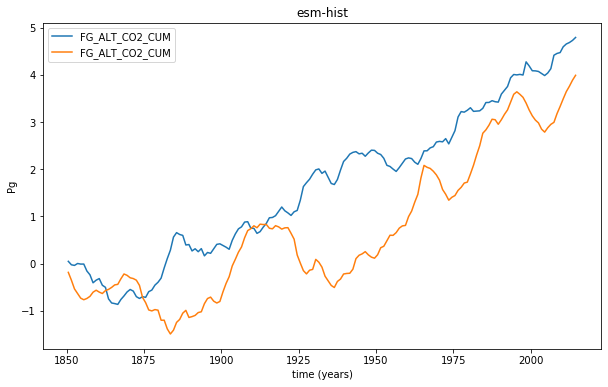

In [15]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([-1.45702254, -2.25858506])

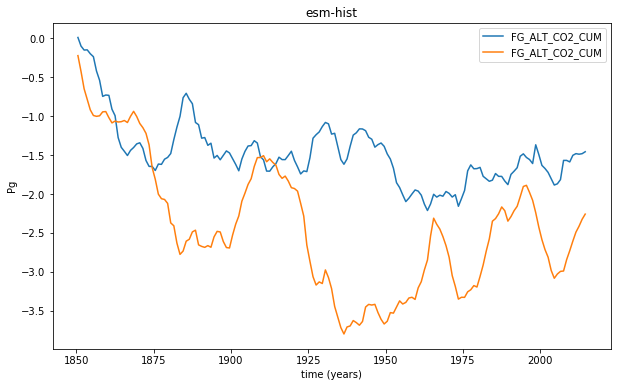

In [16]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

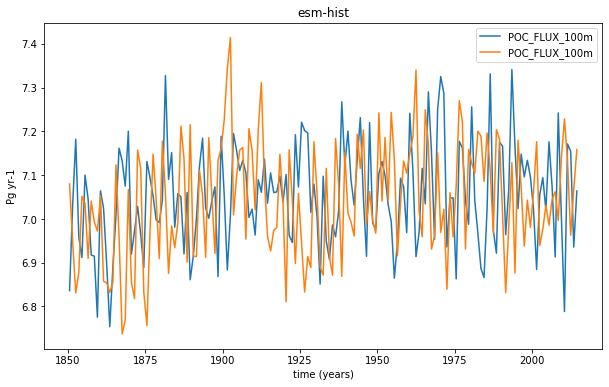

In [17]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['POC_FLUX_100m'], title=experiment, region_val='Global')

array([8.66451421, 6.99422915])

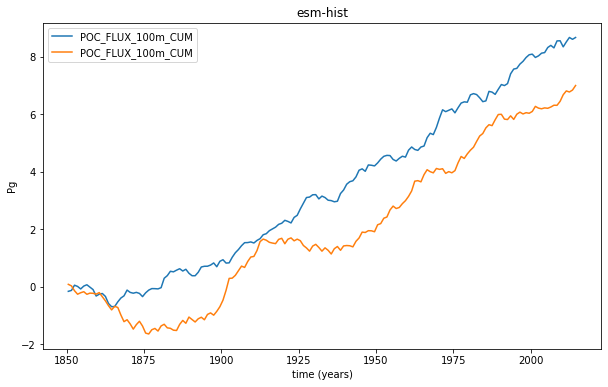

In [18]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['POC_FLUX_100m_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['POC_FLUX_100m_CUM'].sel(region='Global').isel(time=-1).values